# Australian dataset: yearly analysis

In [1]:
%run preamble.py
ausautoBI8999 = pd.read_csv("../Data/ausautoBI8999.csv")

In [2]:
from datetime import datetime
aus = pd.concat([ausautoBI8999[["FinDate", "FinMth" ,"AggClaim"]], 
                 pd.DataFrame({'year':np.array([datetime.fromisoformat(ausautoBI8999["FinDate"].iloc[k]).year 
                                                for k in range(len(ausautoBI8999["FinDate"]))])})
                ], axis = 1)
print(aus[["FinDate", "FinMth", "AggClaim"]].head(5).to_latex(index=False))
print(aus[["AggClaim"]].describe().applymap("{:.2f}".format).to_latex())

\begin{tabular}{lrr}
\toprule
   FinDate &  FinMth &  AggClaim \\
\midrule
1993-10-01 &      52 &     87.75 \\
1994-02-01 &      56 &    353.62 \\
1994-02-01 &      56 &    688.83 \\
1994-05-01 &      59 &    172.80 \\
1994-09-01 &      63 &     43.29 \\
\bottomrule
\end{tabular}

\begin{tabular}{ll}
\toprule
{} &    AggClaim \\
\midrule
count &    22036.00 \\
mean  &    38367.22 \\
std   &    90981.11 \\
min   &        9.96 \\
25\%   &     6296.97 \\
50\%   &    13853.87 \\
75\%   &    35123.42 \\
max   &  4485797.21 \\
\bottomrule
\end{tabular}



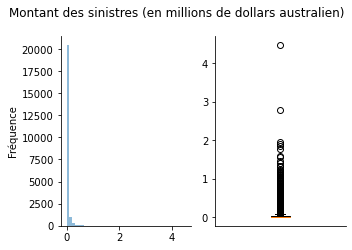

In [4]:
fig, axs = plt.subplots(1,2, figsize=(5, 3.5), tight_layout=True)
num_bins = 40
# the histogram of the data
n, bins, patches = axs[0].hist(aus.AggClaim / 1e6, num_bins, alpha=0.5)
axs[1].boxplot(aus.AggClaim / 1e6)
axs[0].set_xlabel("")
axs[0].set_ylabel("Fréquence")
axs[1].set_ylabel("")
axs[1].set_xticks([])
plt.suptitle("Montant des sinistres (en millions de dollars australien)")
# plt.show()
sns.despine()
plt.savefig("../Figures/hist_box_aus.pdf")

In [4]:
aus['scaled_aggclaims'] = aus['AggClaim'] / 1e6 
aus['scaled_aggclaims'].quantile([0.95, 0.99])
loss_models = ['lnorm-par', 'wei-par', "gam-par"]
X = aus['scaled_aggclaims'].values
model_prior, a, b =  "gamma", 0.1 * np.ones(3), 0.1 * np.ones(3)
# SMC settings
popSize, verbose, smc_method, paralell, nproc = 1000, True, "likelihood_anealing", True, 40
start_time = time()
traces, summary = fit_composite_models_smc(X,loss_models,
                                                     model_prior, a, b, popSize, verbose, smc_method, paralell, nproc)
print("Time: "+str(time() -  start_time))

Fitting lnorm-par model
Fitting wei-par model
Fitting gam-par model
Time: 617.5342967510223


In [5]:
summary

,loss_model,log_marg,DIC,WAIC,shape,tail,thres,model_evidence
0,lnorm-par,54193.138335,-107797.023799,-108415.708740,1.461129,2.438068,2.969760,5.744347e-161
0,wei-par,54558.404410,-109163.091730,-109149.819075,1.052366,1.046519,0.033705,2.467638e-02
0,gam-par,54562.081333,-109170.876501,-109157.508827,1.074636,1.052292,0.034575,9.753236e-01


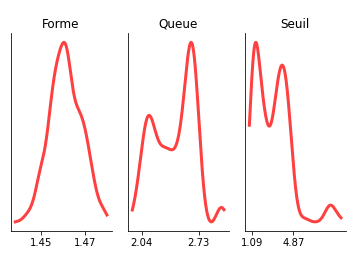

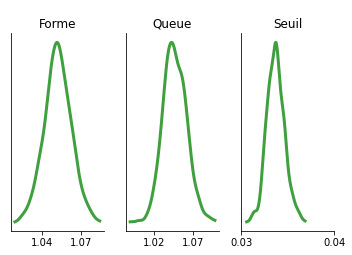

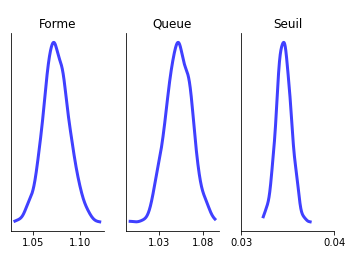

In [6]:
xlabels = ["Forme", "Queue", "Seuil"]
colors = ["red", "green", "blue"]
parms_names = ["shape", "tail", "thres"]
title_labs = ["Forme", "Queue", "Seuil"]

for i, loss_model in enumerate(loss_models):
    fig, axs = plt.subplots(1, 3, figsize=(5, 3.5))
    for k in range(len(parms_names)):

        trace_temp = traces[loss_model]

        positions = np.linspace(min(trace_temp[parms_names[k]]), 
                                max(trace_temp[parms_names[k]]), 1000)
        kernel = st.gaussian_kde(trace_temp[parms_names[k]])
        axs[k].plot(positions, kernel(positions), lw=3, 
                    color = colors[i] , alpha = 0.75)

        axs[k].set_yticks([])
        axs[k].set_title(xlabels[k])
        axs[k].set_xticks(np.round(
        trace_temp[parms_names[k]].quantile([0.05, 0.95]).values, 2))
        
    handles, labels = axs[0].get_legend_handles_labels()
    fig.tight_layout()
    fig.legend(handles, labels, ncol = 2, borderaxespad=0., loc='upper center', 
               frameon=False)
    
    sns.despine()
    plt.savefig("../Figures/posterior_aus_"+str(loss_model)+".pdf")

[1.07463588 1.05229161 0.03457488]


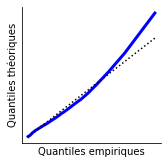

In [7]:
K, loss_model = 100000, 'gam-par'
parms =  traces[loss_model].mean().values
print(parms)
X0 = sim_gam_par(K, parms[0], parms[1], parms[2])
qq_plot(X, X0, "blue")
sns.despine()
plt.savefig("../Figures/QQplot_gam_par_aus.pdf")

[1.0523664  1.04651921 0.03370451]


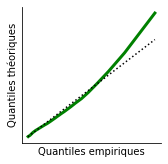

In [8]:
K, loss_model = 100000, 'wei-par'
parms =  traces[loss_model].mean().values
print(parms)
X0 = sim_wei_par(K, parms[0], parms[1], parms[2])
qq_plot(X, X0, "green")
sns.despine()
plt.savefig("../Figures/QQplot_wei_par_aus.pdf")

[1.46112914 2.43806812 2.96975963]


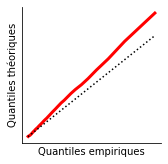

In [9]:
K, loss_model = 100000, 'lnorm-par'
parms =  traces[loss_model].mean().values
print(parms)
X0 = sim_lnorm_par(K, parms[0], parms[1], parms[2])
qq_plot(X, X0, "red")
sns.despine()
plt.savefig("../Figures/QQplot_lnorm_par_aus.pdf")


In [10]:
with pm.Model() as model_sev:
    μ = pm.Normal("mu",mu=0, sigma=10)
    σ = pm.Gamma("sig",alpha = 0.1, beta = 0.1)
    U = pm.Lognormal("U", mu=μ, sigma=σ, observed=X)
    %time trace_lnorm = pm.sample_smc(popSize, random_seed=1, chains = 1)

Initializing SMC sampler...
Multiprocess sampling (1 chain in 1 job)
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.001
Stage:   5 Beta: 0.003
Stage:   6 Beta: 0.009
Stage:   7 Beta: 0.033
Stage:   8 Beta: 0.111
Stage:   9 Beta: 0.375
Stage:  10 Beta: 1.000


CPU times: user 37 s, sys: 1.34 s, total: 38.3 s
Wall time: 16.9 s


-4.259536124437924 1.4630420901173644


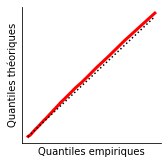

In [11]:
μ, σ = trace_lnorm['mu'].mean(), trace_lnorm['sig'].mean()
print(μ, σ)
X0 = np.random.lognormal(mean = μ, sigma  = σ, size=K)
qq_plot(X, X0, "red")
sns.despine()
plt.savefig("../Figures/QQplot_lnorm_aus.pdf")

In [72]:
from numba import jit
@jit(nopython=True)
def log_like_lnorm(X, mu, σ):
    n = X.size
    return - n * np.log(σ * (2 * ma.pi)**(1/2)) - np.sum(np.log(X)) - np.sum((np.log(X) - mu)**2 / 2 / σ**2)

@jit(nopython=True)
def log_pdf_lnorm(x, mu, σ):
    return - 1 * np.log(σ * (2 * ma.pi)**(1/2)) - np.log(x) - (np.log(x) - mu)**2 / 2 / σ**2
mu, σ = trace_lnorm['mu'].mean(), trace_lnorm['sig'].mean()

μ_map, σ_map = trace_lnorm['mu'].mean(), trace_lnorm['sig'].mean(
log_vrais_map = log_like_lnorm(X, μ_map, σ_map)
log_vrais_map

54210.89083885919

In [74]:
# μ_trace, σ_trace = trace_lnorm['mu'], trace_lnorm['sig']
p_DIC = np.mean([log_like_lnorm(X, μ_trace[k], σ_trace[k]) 
                 for k in range(len(μ_trace))]) - log_vrais_map
p_DIC
DIC = -2 * (log_vrais_map - p_DIC)
DIC
lppd = np.sum([np.log(np.mean([np.exp(log_pdf_lnorm(X[j],μ_trace[k], σ_trace[k])) 
                 for k in range(len(μ_trace))])) for j in range(len(X))])
p_WAIC = np.var([log_like_lnorm(X, μ_trace[k], σ_trace[k]) 
                 for k in range(len(μ_trace))])
WAIC = -2 *(lppd - p_WAIC)
WAIC

-108420.42616415599

In [76]:
log_marg_compo = summary[['loss_model', 'log_marg', 'DIC', "WAIC"]]
log_marg_lnorm = pd.DataFrame({'loss_model': ["lnorm"], 
                               'log_marg' : trace_lnorm.report.log_marginal_likelihood,
                               'DIC':DIC,
                               "WAIC":WAIC})
log_marg_df = pd.concat([log_marg_compo, log_marg_lnorm])
log_marg_df['model_evidence'] = np.exp(log_marg_df['log_marg'] - log_marg_df['log_marg'].max()) / \
np.sum(np.exp(log_marg_df['log_marg'] - log_marg_df['log_marg'].max()))
print(log_marg_df)
print(log_marg_df[['loss_model', 'log_marg',"model_evidence", 'DIC', "WAIC"]].to_latex(float_format="%.2f", index=False))

  loss_model      log_marg            DIC           WAIC  model_evidence
0  lnorm-par  54193.138335 -107797.023799 -108415.708740   5.744347e-161
0    wei-par  54558.404410 -109163.091730 -109149.819075    2.467638e-02
0    gam-par  54562.081333 -109170.876501 -109157.508827    9.753236e-01
0      lnorm  54196.780589 -108423.770855 -108420.426164   2.193064e-159
\begin{tabular}{lrrrr}
\toprule
loss\_model &  log\_marg &  model\_evidence &        DIC &       WAIC \\
\midrule
 lnorm-par &  54193.14 &            0.00 & -107797.02 & -108415.71 \\
   wei-par &  54558.40 &            0.02 & -109163.09 & -109149.82 \\
   gam-par &  54562.08 &            0.98 & -109170.88 & -109157.51 \\
     lnorm &  54196.78 &            0.00 & -108423.77 & -108420.43 \\
\bottomrule
\end{tabular}



In [17]:
parms_names = ["shape", "tail", "thres"]
summary['index'] = np.arange(0, 3, 1)
q_compo = pd.DataFrame(np.array([[quantile_compo(0.95, summary['loss_model'].iloc[k], summary[parms_names].iloc[k].values), 
     quantile_compo(0.99, summary['loss_model'].iloc[k], summary[parms_names].iloc[k].values )] 
                              for k in range(len(summary))]), 
                        index = np.arange(0, 3, 1))
q_compo.columns = ['q95', 'q99']
q_compo['loss_model'] = loss_models
# q_compo = pd.merge(summary, q_compo.reset_index()).set_index('index')
mu, sig = trace_lnorm['mu'].mean(), trace_lnorm['sig'].mean()
q_lnorm = pd.DataFrame(st.lognorm(s = sig , scale = np.exp(mu)).ppf([0.95, 0.99])).T
q_lnorm.columns = ['q95','q99']
q_lnorm['loss_model'] = 'lnorm'
q_loss = pd.merge(pd.concat([q_compo, q_lnorm]),log_marg_df, on = 'loss_model' )
q_ens = pd.DataFrame({'q95':np.dot(q_loss['q95'].values, q_loss['model_evidence'].values),
                      'q99':np.dot(q_loss['q99'].values, q_loss['model_evidence'].values)
                     }, index = [0])
q_ens['loss_model'] = "ensemble"
q_emp = pd.DataFrame(aus['scaled_aggclaims'].quantile([0.95, 0.99])).T
q_emp.columns = ["q95", "q99"]
q_emp['loss_model'] = "empirical"
q_emp
q_df = pd.concat([q_loss[['loss_model', "q95", "q99"]], q_ens, q_emp])
print(q_df.to_latex(float_format="%.2f", index=False))
q_df

\begin{tabular}{lrr}
\toprule
loss\_model &  q95 &  q99 \\
\midrule
 lnorm-par & 0.18 & 0.48 \\
   wei-par & 0.15 & 0.70 \\
   gam-par & 0.15 & 0.69 \\
     lnorm & 0.16 & 0.42 \\
  ensemble & 0.15 & 0.69 \\
 empirical & 0.15 & 0.39 \\
\bottomrule
\end{tabular}



,loss_model,q95,q99
0,lnorm-par,0.175184,0.475041
1,wei-par,0.150691,0.699894
2,gam-par,0.150074,0.693121
3,lnorm,0.156759,0.424862
0,ensemble,0.150087,0.693256
scaled_aggclaims,empirical,0.148715,0.394254


      shape     scale            AIC            BIC
0  1.462421 -4.259138 -108417.791268 -108401.790402


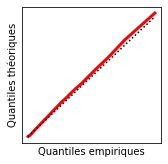

In [19]:
σ,μ, BIC, AIC = infer_lnorm(X)
fit_lnorm = pd.DataFrame({'shape': np.array([σ]), "scale": np.array([μ]),"AIC":np.array([AIC]),"BIC":np.array([BIC])  })
print(fit_lnorm)
X0 = np.random.lognormal(mean = μ, sigma  = σ, size=K)
qq_plot(X, X0, "red")

      shape      tail     thres            AIC            BIC
0  1.074505  1.052334  0.034568 -109158.327083 -109134.325785


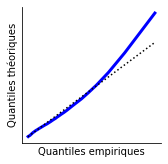

In [21]:
parms, BIC, AIC = mle_composite(X, (1,1,0.1), "gam-par")
fit_gam_par = pd.DataFrame(np.append(parms, [AIC, BIC])).T
fit_gam_par.columns = ["shape", "tail", "thres", "AIC","BIC"]
print(fit_gam_par)
X0 = sim_gam_par(K, parms[0], parms[1], parms[2])
qq_plot(X, X0, "blue")
sns.despine()
# plt.savefig("../Figures/QQplot_gam_par.pdf")